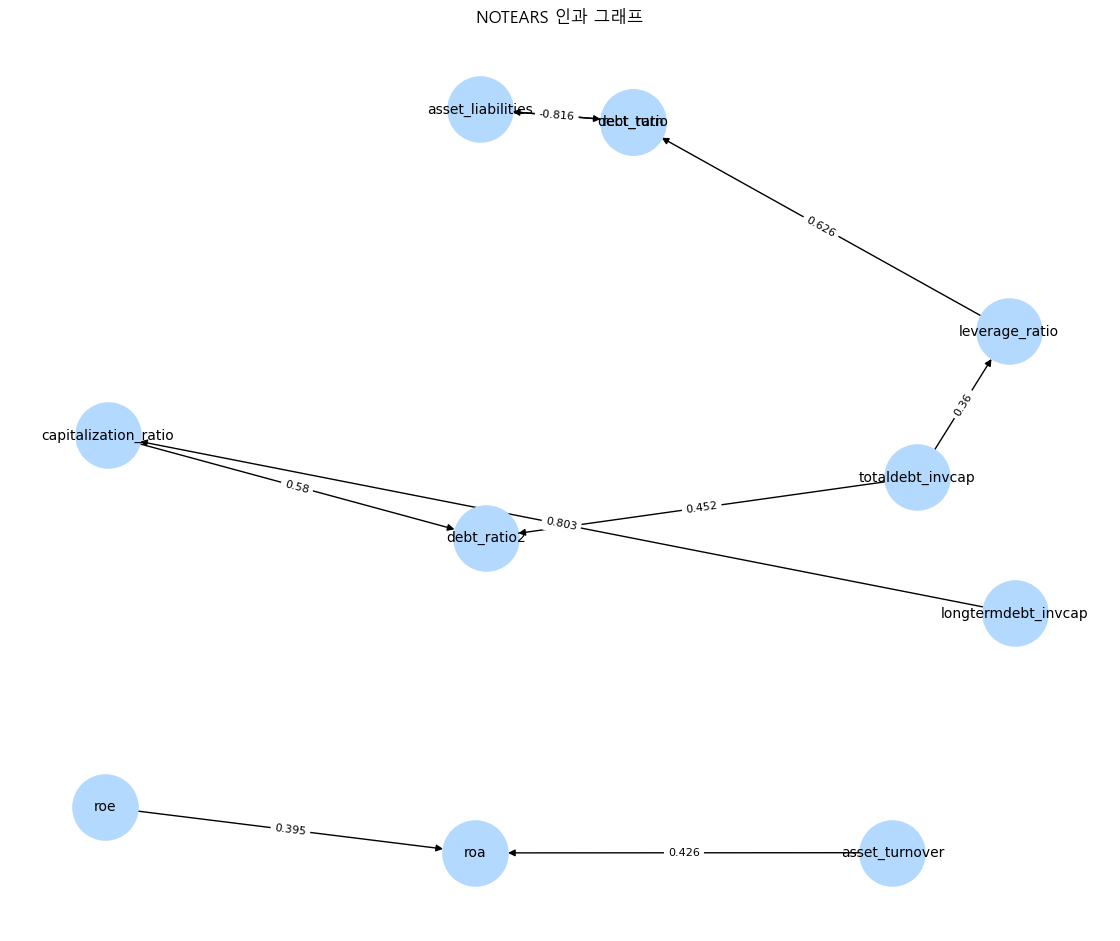

In [6]:
# === Imports (NO SHAP HERE) ===
import os, re, json
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from joblib import dump, load

import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

from notears.linear import notears_linear

# === Config ===
SAVE_DIR = Path("./exp_outputs")   # 실험 저장 루트
SAVE_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.2
LAMBDA1 = 0.1
W_THRESHOLD = 0.01
USE_QUANTILE = False
W_ABS_QUANTILE = 0.90

PARAM_GRID = { "logreg__C": [0.1, 1.0, 10.0], "logreg__penalty": ["l2"] }

MODES = [
    "original",
    "mul","sub","mul*w","sub*w",
    "mul+sub","mul+mul*w","mul+sub*w","sub+mul*w","sub+sub*w",
    "mul*w+sub*w","mul+mul*w+sub*w","mul+sub+mul*w","mul+sub+sub*w",
    "sub+mul*w+sub*w","mul+sub+mul*w+sub*w",
]

def safe_name(name: str) -> str:
    s = name.replace("+","_").replace("*","_")
    return re.sub(r'[<>:"/\\|?*\s]+', "_", s)

def short_mode_name(mode: str) -> str:
    s = mode.replace("mul*w","mw").replace("sub*w","sw").replace("mul","m").replace("sub","s")
    return safe_name(s)

# 글꼴은 선택사항
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'
except Exception:
    pass
matplotlib.rcParams['axes.unicode_minus'] = False

# === Load ===
df = pd.read_csv("./training_data.csv")
feature_cols = df.drop(columns=["Unnamed: 0", "label"]).columns
X_base = df[feature_cols].copy()
y = df["label"].astype(int)
cols = feature_cols.tolist()

# === NOTEARS ===
X_for_dag = StandardScaler().fit_transform(X_base.values)
W = notears_linear(X_for_dag, lambda1=LAMBDA1, loss_type='l2')
np.save(SAVE_DIR / "W.npy", W)  # 재사용

# === DAG 시각화 (참고) ===
def get_w_threshold(W, fixed_thr=0.01, use_quantile=False, q=0.9):
    if not use_quantile: return fixed_thr
    aw = np.abs(W).ravel()
    aw = aw[aw>0]
    return float(np.quantile(aw, q)) if aw.size else fixed_thr

thr_for_graph = get_w_threshold(W, W_THRESHOLD, USE_QUANTILE, W_ABS_QUANTILE)
G = nx.DiGraph()
for i in range(len(cols)):
    for j in range(len(cols)):
        if i==j: continue
        if abs(W[i,j]) > thr_for_graph:
            G.add_edge(cols[j], cols[i], weight=round(float(W[i,j]),3))

plt.figure(figsize=(11,9))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2200, node_color="#b3d9ff", font_size=10, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'), font_size=8)
plt.title("NOTEARS 인과 그래프")
plt.savefig(SAVE_DIR / "dag_graph.png", dpi=180, bbox_inches="tight")
plt.show()


In [9]:
def generate_added_features(X_base: pd.DataFrame, cols, W: np.ndarray, mode: str,
                            w_threshold: float = 0.01, use_quantile: bool = False, q: float = 0.90) -> pd.DataFrame:
    new_features = pd.DataFrame(index=X_base.index)

    # --- 정확한 토큰 파싱 ---
    tokens = set(mode.split("+"))  # 예: {'mul', 'sub', 'mul*w', 'sub*w'}

    # original 모드는 추가 피처 없음
    if tokens == {"original"} or mode == "original":
        return new_features

    # --- 임계값 계산(그래프와 동일 로직/파라미터 사용 권장) ---
    thr = get_w_threshold(W, fixed_thr=w_threshold, use_quantile=use_quantile, q=q)

    for i in range(len(cols)):
        for j in range(len(cols)):
            if i == j:
                continue
            w_ij = float(W[i, j])
            if abs(w_ij) <= thr:
                continue

            A = cols[j]  # 원인(부모)
            B = cols[i]  # 결과(자식)

            # 미가중 토큰
            if "mul" in tokens:
                new_features[f"{A}_mul_{B}"] = X_base[A] * X_base[B]
            if "sub" in tokens:
                new_features[f"{A}_sub_{B}"] = X_base[A] - X_base[B]

            # 가중 토큰
            if "mul*w" in tokens:
                new_features[f"{A}_mulw_{B}"] = w_ij * (X_base[A] * X_base[B])
            if "sub*w" in tokens:
                new_features[f"{A}_subw_{B}"] = w_ij * (X_base[A] - X_base[B])

    return new_features


def build_dataset_by_setting(mode, setting, X_base, cols, W):
    if setting == "original":
        return X_base.copy()
    X_added = generate_added_features(X_base, cols, W, mode)
    if setting == "feature_only":
        return X_added
    if setting == "original_plus_feature":
        return pd.concat([X_base, X_added], axis=1)
    raise ValueError(setting)

def train_and_save(X, y, out_dir: Path,
                   random_state=RANDOM_STATE, test_size=TEST_SIZE,
                   param_grid=PARAM_GRID):
    out_dir.mkdir(parents=True, exist_ok=True)

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    (tr_idx, te_idx), = splitter.split(X, y)
    X_train, X_test = X.iloc[tr_idx], X.iloc[te_idx]
    y_train, y_test = y.iloc[tr_idx], y.iloc[te_idx]

    penalties = param_grid.get("logreg__penalty", ["l2"])
    solver = "liblinear" if ("l1" in penalties) else "lbfgs"

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            random_state=random_state,
            solver=solver,
            max_iter=200,
            class_weight="balanced"
        ))
    ])

    grid = GridSearchCV(pipe, param_grid, scoring="f1", cv=3, n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)
    best_pipe = grid.best_estimator_

    # Evaluate (간단 메트릭)
    y_pred = best_pipe.predict(X_test)
    metrics = {
        "f1": f1_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred)
    }

    # Save artifacts (SHAP과 무관)
    dump(best_pipe, out_dir / "model.joblib")
    X_test.to_parquet(out_dir / "X_test.parquet")
    y_test.to_frame("label").to_parquet(out_dir / "y_test.parquet")

    with open(out_dir / "metrics.json", "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

    with open(out_dir / "report.txt", "w", encoding="utf-8") as f:
        f.write(classification_report(y_test, y_pred, digits=4))

    return metrics


In [ ]:
registry = []  # 각 실험의 성능 요약 테이블

SETTINGS = ["original", "feature_only", "original_plus_feature"]
for setting in SETTINGS:
    for mode in MODES:
        X = build_dataset_by_setting(mode, setting, X_base, cols, W)
        if X is None or X.shape[1]==0:
            continue
        mode_short = short_mode_name(mode)
        out_dir = SAVE_DIR / setting / mode_short
        try:
            metrics = train_and_save(X, y, out_dir)
            row = {
                "setting": setting,
                "mode": mode,
                "mode_short": mode_short,
                "n_features": X.shape[1],
                "f1": metrics["f1"],
                "accuracy": metrics["accuracy"],
                "precision": metrics["precision"],
                "recall": metrics["recall"],
                "exp_dir": str(out_dir.resolve())
            }
            registry.append(row)
        except Exception as e:
            print(f"[error] {setting}/{mode}: {e}")

reg_df = pd.DataFrame(registry).sort_values(["f1","accuracy"], ascending=False).reset_index(drop=True)
reg_df.to_csv(SAVE_DIR / "registry_Logistic_reg.csv", index=False)
reg_df.head(10)


,setting,mode,mode_short,n_features,f1,accuracy,precision,recall,exp_dir
0,original_plus_feature,mul+mul*w,m_mw,31,0.157778,0.788091,0.086480,0.898734,D:\University\3-1.5\PADA Lab\project\bank fail...
1,original_plus_feature,mul+sub+mul*w+sub*w,m_s_mw_sw,49,0.157778,0.788091,0.086480,0.898734,D:\University\3-1.5\PADA Lab\project\bank fail...
2,original_plus_feature,mul,m,22,0.157603,0.787811,0.086375,0.898734,D:\University\3-1.5\PADA Lab\project\bank fail...
3,original_plus_feature,mul*w,mw,22,0.157603,0.787811,0.086375,0.898734,D:\University\3-1.5\PADA Lab\project\bank fail...
4,original_plus_feature,mul+sub,m_s,31,0.157603,0.787811,0.086375,0.898734,D:\University\3-1.5\PADA Lab\project\bank fail...
5,original_plus_feature,mul+sub*w,m_sw,31,0.157603,0.787811,0.086375,0.898734,D:\University\3-1.5\PADA Lab\project\bank fail...
6,original_plus_feature,sub+mul*w,s_mw,31,0.157603,0.787811,0.086375,0.898734,D:\University\3-1.5\PADA Lab\project\bank fail...
7,original_plus_feature,mul*w+sub*w,mw_sw,31,0.157603,0.787811,0.086375,0.898734,D:\University\3-1.5\PADA Lab\project\bank fail...
8,original_plus_feature,mul+mul*w+sub*w,m_mw_sw,40,0.157603,0.787811,0.086375,0.898734,D:\University\3-1.5\PADA Lab\project\bank fail...
9,original_plus_feature,mul+sub+mul*w,m_s_mw,40,0.157603,0.787811,0.086375,0.898734,D:\University\3-1.5\PADA Lab\project\bank fail...
